---

#### Title: "Interpretando un Algoritmo de ML Enfocado a un Score de credito"

#### Date: 2020-09-09

#### Tags: Analytics, Credit Risk, R, Machine Learning Interpretability, H2O


#### Excerpt: "Analytics,H2O, Credit Risk, Machine Learning Interpretability"

#### Packages: TeachingSampling, h2o:3.26.0.2, iml, DALEX, dplyr

---

<br>
En esta práctica se mostrará como desarrollar e interpretar un algoritmo de machine learning, enfocado al riesgo de crédito.

Para esta práctica se van a utilizar los datos del siguiente reto [CREDIT_RISK](https://www.kaggle.com/c/home-credit-default-risk/data?select=HomeCredit_columns_description.csv), el dataset desarrollado será subido a este repositorio.

<br>

### Paso 1:

Lo primero que se hace despues de haber unido las tablas para desarrollar el modelo, es seleccionar las variables que se usaran dentro del algoritmo.

Para ello, se utilizo una tecnica llamada RFE ([recursive feature elimination](http://www.feat.engineering/recursive-feature-elimination.html)):

In [28]:
load(file="D:/2020_1/MCH_Interpretability/DATA_PROJECT_02222020.RData") ## Data set 

In [2]:
dim(DATA_PROJECT) ## Dimension de la tabla

[1] 685900    162

Dado que son 162 variables, la idea será reducirlas y solo trabajar con las características que aporten información significativa.

Para no tener problemas con el tiempo de procesamiento, se hará un muestreo estratificado con respecto a la variable "TARGET" del 10%. Con esta muestra se realizará el proceso.

In [8]:
table(DATA_PROJECT$TARGET)



     0      1 
651573  34327 

In [23]:
defaultW <- getOption("warn") 

options(warn = -1) 
library(TeachingSampling)

Nh = c(651573,34327) ## El tamaño de cada estrato
nh <- c(6515,500) ## El tamaño de la distribucion de la muestra

res<-S.STSI(DATA_PROJECT$TARGET, Nh, nh)

DATA_SAM = DATA_PROJECT[res,]

In [24]:
dim(DATA_SAM) ## Tamaño de la muestra

[1] 66874   162

In [25]:
head(DATA_SAM)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY.x,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>
1,100145,0,Cash loans,F,Y,Y,1,202500,260725.5,16789.5,...,0,0,0,0,0,0,21,Active,0,0
13,100145,0,Cash loans,F,Y,Y,1,202500,260725.5,16789.5,...,0,0,0,0,0,0,22,Active,0,0
14,100145,0,Cash loans,F,Y,Y,1,202500,260725.5,16789.5,...,0,0,0,0,0,0,22,Active,0,0
15,100145,0,Cash loans,F,Y,Y,1,202500,260725.5,16789.5,...,0,0,0,0,0,0,22,Active,0,0
17,100145,0,Cash loans,F,Y,Y,1,202500,260725.5,16789.5,...,0,0,0,0,0,0,22,Active,0,0
40,100145,0,Cash loans,F,Y,Y,1,202500,260725.5,16789.5,...,0,0,0,0,0,0,22,Active,0,0


In [ ]:
DATA_SAM = DATA_SAM[,2:162]
DATA_SAM$TARGET = as.factor(as.character(DATA_SAM$TARGET)) 

library(doParallel)
library(caret)
cl <- makePSOCKcluster(8)
registerDoParallel(cl)
ctrl <- rfeControl(functions =rfFuncs,number = ifelse(method %in% c("cv",
  "repeatedcv"), 1, 5))

set.seed(1)
lmProfile2 <- rfe(DATA_SAM[,2:161], DATA_SAM$TARGET,
                  sizes = c(10,25,30,40), rfeControl = ctrl)  ## el metodo iterara con 10, 25, 30 ,35 y 40 variabes.



stopCluster(cl)

<br>
El resultado del código anterior podrá ser encontrado en el repositorio

<br>

In [6]:
load(file="D:/2020_1/MCH_Interpretability/FTL_RES.RData") ## Objeto.

<br>
Del objeto solo se tomarán los dataframes ("results","variable"), ya que allí se encuentran los resultados que se necesitan para continuar.
<br>

<br>

#### Cantidad de variables optimas:

In [7]:
defaultW <- getOption("warn") 
A_1 =  lmProfile2$results

A_1 = A_1[order(-A_1$Accuracy,-A_1$Kappa) ,]

head(A_1)

,Variables,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,25,0.9993940,0.9954358,0.0007256914,0.005376993
3,30,0.9993630,0.9951932,0.0007151947,0.005298739
4,40,0.9993630,0.9951932,0.0007151947,0.005298739
1,10,0.9992556,0.9943629,0.0009080693,0.006791870


<br>
La idea es escoger el conjunto de variables que tenga el Accuracy y Kappa más altos. En este caso el mejor grupo de variables es el de "25".


<br>

#### Variables dentro del grupo optimo:

In [10]:
A_2 = lmProfile2$variables
A_2 = A_2[A_2$Variables ==25,1:5]
head(A_2)

,0,1,Overall,var,Variables
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
71,23.30000,23.30000,23.30000,EXT_SOURCE_1,25
72,23.05532,23.05532,23.05532,EXT_SOURCE_2,25
73,22.96995,22.96995,22.96995,ORGANIZATION_TYPE,25
74,17.18718,17.18718,17.18718,DAYS_LAST_PHONE_CHANGE,25
75,15.33767,15.33767,15.33767,OCCUPATION_TYPE,25
76,14.25884,14.25884,14.25884,EXT_SOURCE_3,25


<br>
Como para desarrollar el rfe se usó resampling, se escogerán las variables que más fueron muestreadas dentro del algoritmo.
<br>

In [11]:
VAES = data.frame(table(A_2$var)) 
VAES = VAES[order(-VAES$Freq) ,]
head(VAES,25)

,Var1,Freq
,<fct>,<int>
1,AMT_INCOME_TOTAL,25
2,APARTMENTS_AVG,25
3,APARTMENTS_MEDI,25
10,DAYS_LAST_PHONE_CHANGE,25
11,DAYS_REGISTRATION,25
14,EXT_SOURCE_1,25
15,EXT_SOURCE_2,25
16,EXT_SOURCE_3,25
22,LIVINGAREA_AVG,25


<br>
Estas fueron las 25 variables más significativas dentro del ejercicio.

Ellas serán  usadas para poder desarrollar un algoritmo que prediga a la variable "TARGET".



<br>

## Desarrollo del Score financiero:

<br>
Como ya se escogieron las variables, se filtran dichas características dentro del primer data set para crear el modelo.

In [12]:
variables= c("TARGET",as.vector(VAES[1:25,"Var1"]))


In [31]:
DATA_PROJECT_MODEL = DATA_PROJECT[,variables]

DATA_PROJECT_MODEL$EXT_SOURCE_1 = round(DATA_PROJECT_MODEL$EXT_SOURCE_1*1000,0) 
DATA_PROJECT_MODEL$EXT_SOURCE_2= round(DATA_PROJECT_MODEL$EXT_SOURCE_2*1000,0) 
DATA_PROJECT_MODEL$EXT_SOURCE_3= round(DATA_PROJECT_MODEL$EXT_SOURCE_3*1000,0) 




La transformación anterior se hizo ya que estas variables son puntajes financieros que se encuentran en una escala decimal.

In [30]:
dim(DATA_PROJECT_MODEL)

[1] 685900     26

<br>

#### Desarrollo modelo final

In [1]:
defaultW <- getOption("warn") 
library(h2o)

h2o.init(max_mem_size = "10G",nthreads=-1)

Warning message:
"package 'h2o' was built under R version 3.6.3"
----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 days 15 hours 
    H2O cluster timezone:       America/Bogota 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    5 months and 5 days !!! 
    H2O cluster name:           H2O_started_from_R_ASUS_rgl042 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   9.83 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.1 (2019-07-05) 


Warning message in h2o.clusterInfo():
"
Your H2O cluster version is too old (5 months and 5 days)!
Please download and install the latest version from http://h2o.ai/download/"

In [11]:

DATA_1 = as.h2o(DATA_PROJECT_MODEL)
DATA_1$TARGET = as.factor(as.character(DATA_1$TARGET))



H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\ASUS\AppData\Local\Temp\RtmpcxVgYS\file2cc012e677c/h2o_ASUS_started_from_r.out
    C:\Users\ASUS\AppData\Local\Temp\RtmpcxVgYS\file2cc04ac33ad8/h2o_ASUS_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         9 seconds 169 milliseconds 
    H2O cluster timezone:       America/Bogota 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    5 months and 3 days !!! 
    H2O cluster name:           H2O_started_from_R_ASUS_rgl042 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   10.67 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    

Warning message in h2o.clusterInfo():
"
Your H2O cluster version is too old (5 months and 3 days)!
Please download and install the latest version from http://h2o.ai/download/"


  |======================================================================| 100%


<br>

<br>
Se divide el dataset en tres subconjuntos:

-70% train

-20% valid

-10% test

In [12]:
splits <- h2o.splitFrame(data=DATA_1, ratios=c(0.7,0.2))  
train <- splits[[1]]
valid <- splits[[2]]
test <- splits[[3]]


In [14]:
target <- "TARGET"

predictors <- setdiff(names(train), target)


automl_h2o_models <- h2o.automl(
  x = predictors, 
  y = target,
  training_frame= train, nfolds = 0,max_models=20, sort_metric = c("logloss"),balance_classes = TRUE,exclude_algos=c("DeepLearning","StackedEnsemble"))

lb <- h2o.get_leaderboard(automl_h2o_models)

automl_leader <- automl_h2o_models@leader


  |                                                                      |   0%
  |======================================================================| 100%


<br>
Se usa la función "automl" que compara varios algoritmos dentro de la librería y selecciona el mejor con respecto a la métrica de "logloss". Para este ejercicio no se tuvo en cuenta los modelos "DeepLearning" y "StackedEnsemble", ya que computacionalmente son bastante costosos.


In [38]:
automl_leader@model$validation_metrics

H2OBinomialMetrics: gbm
** Reported on validation data. **

MSE:  6.784022e-32
RMSE:  2.604616e-16
LogLoss:  1.452516e-17
Mean Per-Class Error:  0
AUC:  1
AUCPR:  1
Gini:  1
R^2:  1

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           0    1    Error      Rate
0      45897    0 0.000000  =0/45897
1          0 2379 0.000000   =0/2379
Totals 45897 2379 0.000000  =0/48276

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold        value idx
1                       max f1  1.000000     1.000000   0
2                       max f2  1.000000     1.000000   0
3                 max f0point5  1.000000     1.000000   0
4                 max accuracy  1.000000     1.000000   0
5                max precision  1.000000     1.000000   0
6                   max recall  1.000000     1.000000   0
7              max specificity  1.000000     1.000000   0
8             max absolute_mcc  1.000000     1.000000   0
9

<br>
El modelo escogido por la función fue un Gradient Boosting Machine. De igual forma, el archivo del algoritmo será colgado en el repositorio.

<br>

### Interpretacion Global Modelo:

<br>
La primera tarea que se realiza dentro de este segmento es ver el peso de las variables que componen el algoritmo:

<br>

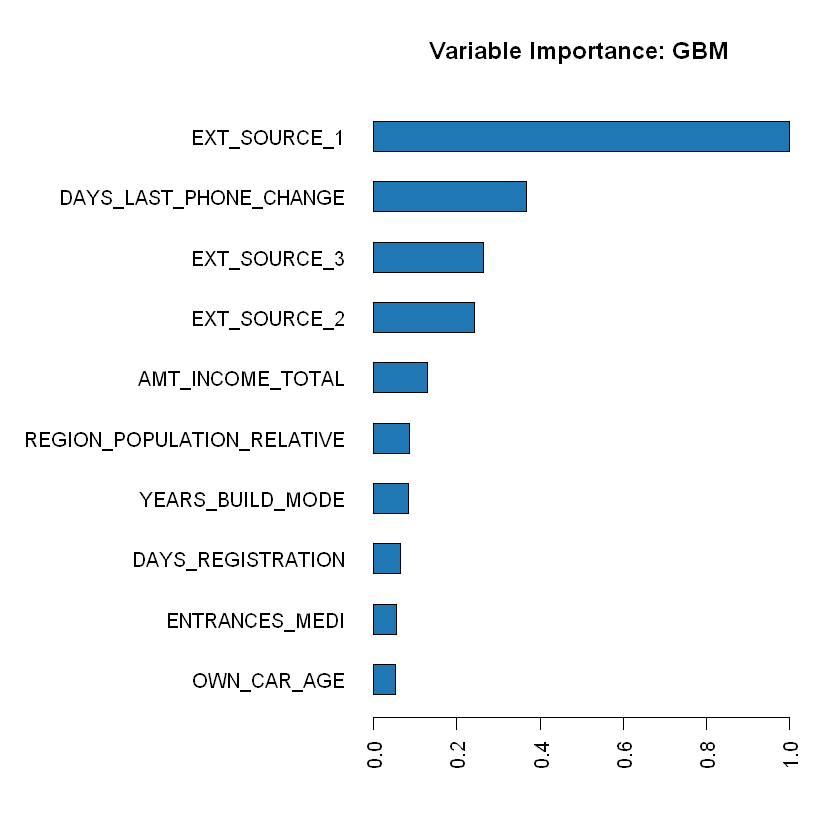

In [3]:
h2o.varimp_plot(automl_leader)

<br>

Dentro de las 5 variables que más pesan se encuentran los puntajes financieros provenientes de otras centrales de riesgo (EXT_SOURCE_1, EXT_SOURCE_2 y EXT_SOURCE_3), seguido por el income total. 

El análisis de la variable "DAYS_LAST_PHONE_CHANGE" se omite ya que dentro de la lógica de negocio no tiene mucho sentido analizarla. Inclusive para una versión 2.0 del modelo, este tipo de características podrían ser removidas.


<br>
Ahora bien, como no se sabe el efecto que tiene cada variable en cuando a la disminución o aumento del riesgo de no pago. Se aplica la técnica de [ALE_PLOTS](https://christophm.github.io/interpretable-ml-book/ale.html) para poder hacer esta descripción.

<br>

## ALE PLOTS:

<br>

In [15]:
defaultW <- getOption("warn") 

library(dplyr)
library(iml)
library(DALEX)
library(TeachingSampling)

# 2. Create a vector with the actual responses
response <- as.numeric(as.vector(DATA_PROJECT_MODEL$TARGET))

# 3. Create custom predict function that returns the predicted values as a
#    vector (probability of purchasing in our example)
pred <- function(model, newdata)  {
  results <- as.data.frame(h2o.predict(model, as.h2o(newdata)))
  return(results[[3L]])
}

In [18]:
table(DATA_PROJECT_MODEL$TARGET)

## Sample:
Nh = c(651573,34327)
nh <- c(65158,3433)

res<-S.STSI(DATA_PROJECT_MODEL$TARGET, Nh, nh)

DATA_SAM = DATA_PROJECT_MODEL[res,]

response_1 <- as.numeric(as.vector(DATA_SAM$TARGET))


     0      1 
651573  34327 

In [19]:
predictor.gbm <- Predictor$new(
  model = automl_leader, 
  data = DATA_SAM, 
  y = response_1, 
  predict.fun = pred,
  class = "classification"
)



#### EXT_SOURCE_1


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


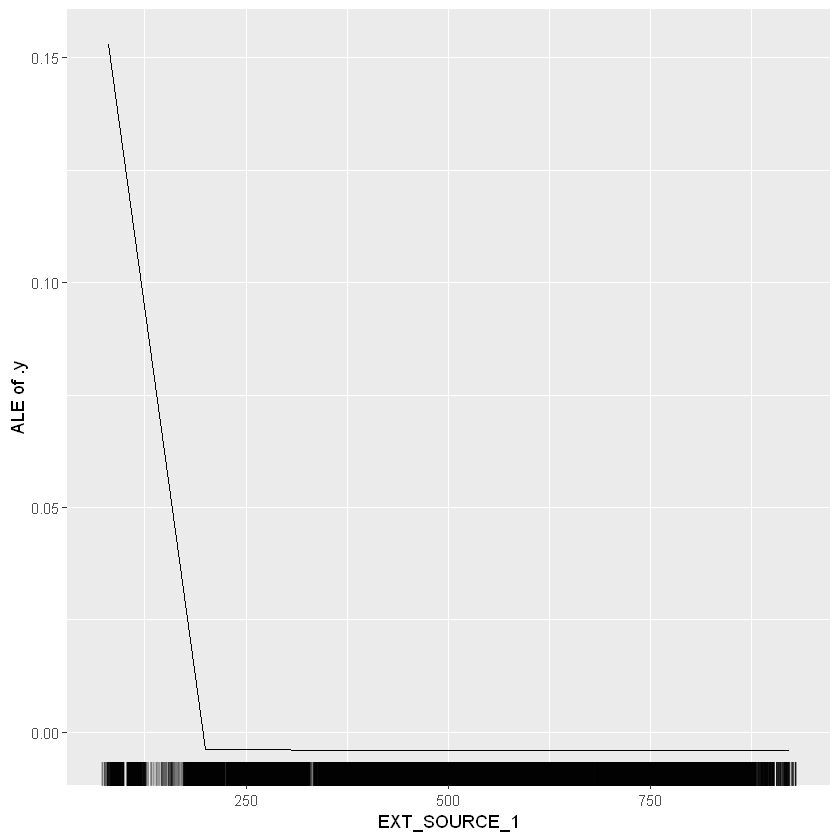

In [20]:
## Ale plots:


ale = FeatureEffect$new(predictor.gbm, feature = "EXT_SOURCE_1")

ale$plot()

Lo que indica la gráfica es que el riesgo de no pago se reduce significativamente cuando una persona tiene un Score de crédito mayor a los 200 puntos en esta central de riesgo.

<br>

#### EXT_SOURCE_2

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


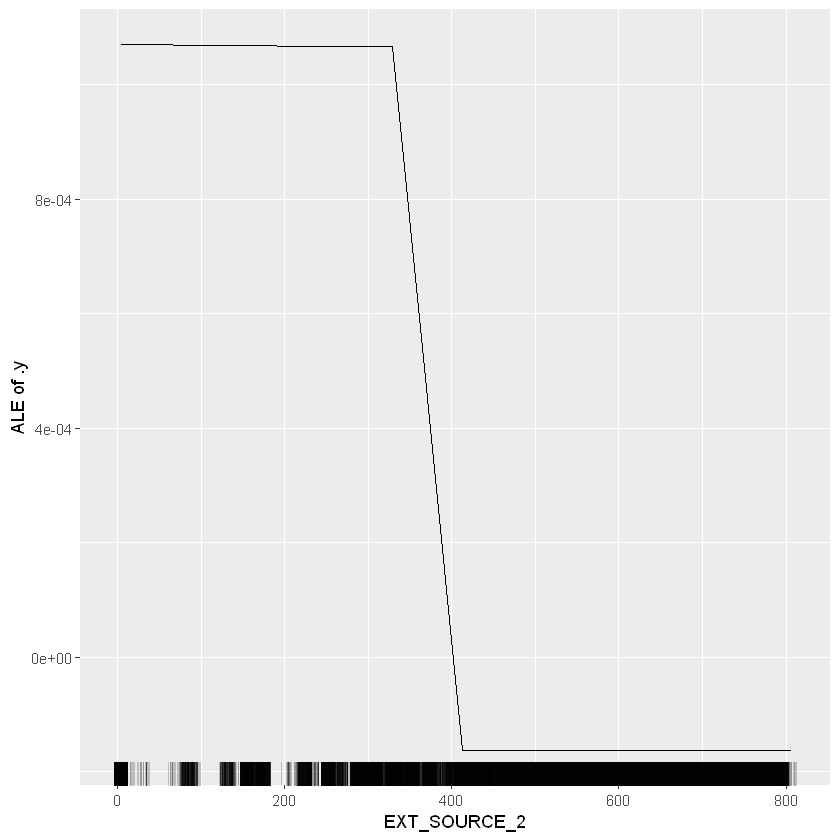

In [21]:

ale = FeatureEffect$new(predictor.gbm, feature = "EXT_SOURCE_2")

ale$plot()

Lo que indica la gráfica es que el riesgo de no pago se reduce significativamente cuando una persona tiene un Score de crédito mayor a los 400 puntos en esta central de Riesgo.

<br>

#### EXT_SOURCE_3

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


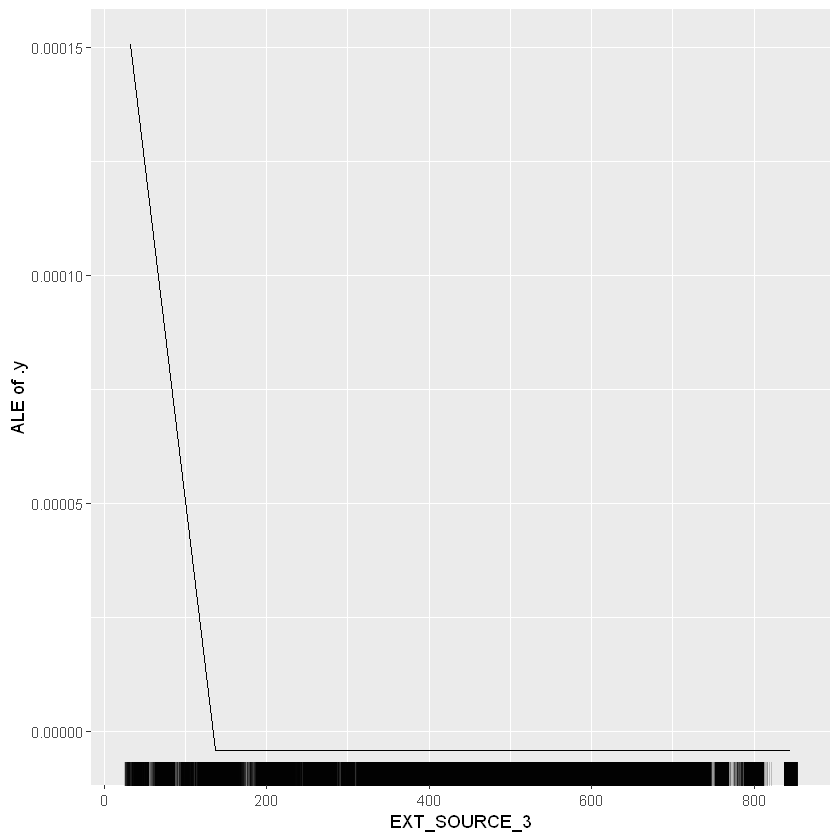

In [24]:
ale = FeatureEffect$new(predictor.gbm, feature = "EXT_SOURCE_3")

ale$plot()


Lo que indica la gráfica es que el riesgo de no pago se reduce significativamente cuando una persona tiene un Score de crédito mayor a los 150 puntos en esta central de Riesgo.


<br>

#### AMT_INCOME_TOTAL

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


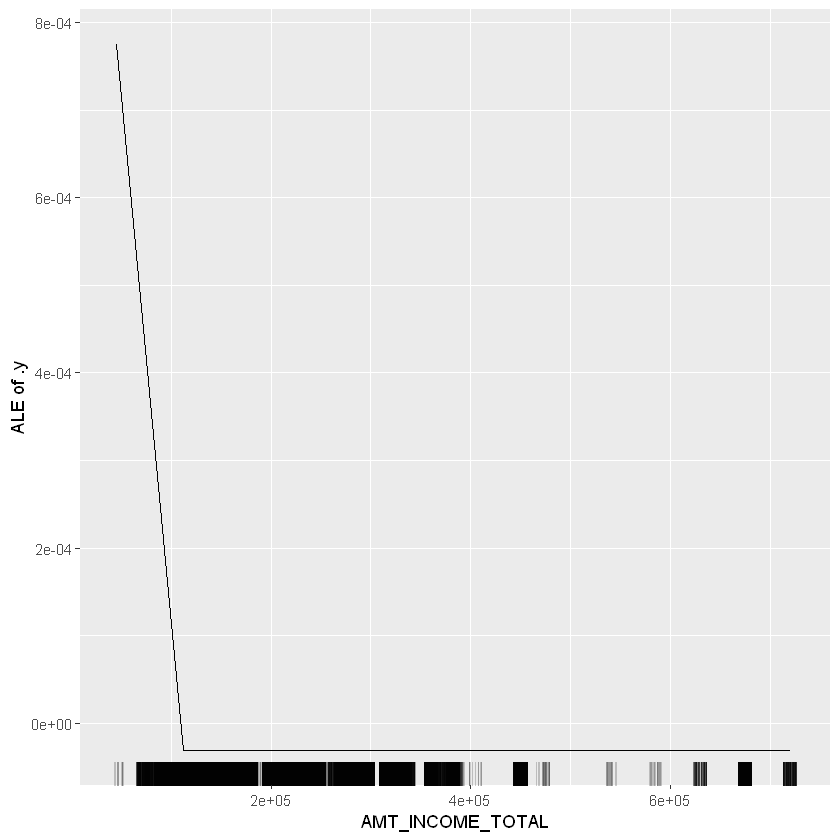

In [26]:
ale = FeatureEffect$new(predictor.gbm, feature = "AMT_INCOME_TOTAL")

ale$plot()

Lo que indica la gráfica es que el riesgo de no pago se reduce significativamente cuando una persona tiene un Income total mayor a los USD 200000.

En conclusión, se podría definir al candidato optimo con las siguientes características:


- Más de 200 puntos en la central 1
- Más de 400 puntos en la central 2
- Más de 150 puntos en la central 3
- Sus ingresos en total son más de USD 200000.




<br>

##### Nota Aclaratoria:

No seria correcto afirmar que este modelo esta listo para ser puesto en produccion ya que el sobreajuste que tiene es alto.

Adicionalmente, los ejemplos de Interpretacion global se hicieron con una muestra de los datos originales por cuestiones de costo computacional.